# COSC 6364 Project Source Code

# Topic: Filter multi-dimensional signal using Fourier domain transformation


## 1. Butterworth low-pass filter for denoising an image using Fourier transform techniques:

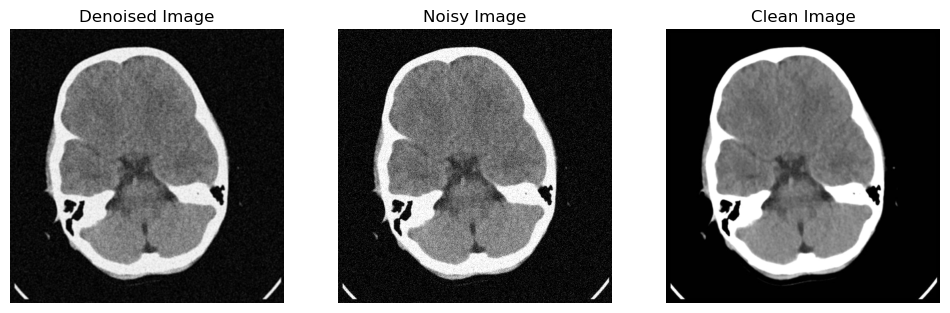

Comparison Metrics:

Mean Squared Error: 0.0017970822550402938
SNR of Noisy Image: 14.16 dB
SNR of Denoised Image: 19.88 dB
Structural Similarity Index (SSIM): 0.4326
Peak Signal-to-Noise Ratio (PSNR): 27.4543


In [1]:
#Code with Butterworth low-pass filter

# Import Required libraries

import numpy as np
import matplotlib.pyplot as plt
from skimage import io, img_as_float, img_as_ubyte
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
from sklearn.metrics import mean_squared_error


# Load your images
noisy_image_path = 'dataset/Noisy-10/ct118.png'
clean_image_path = 'dataset/Clean-10/ct118.png'

noisy_image = img_as_float(io.imread(noisy_image_path, as_gray=True))
clean_image = img_as_float(io.imread(clean_image_path, as_gray=True))

# Apply Fourier transform to the noisy image
f_transform = np.fft.fft2(noisy_image)
f_shift = np.fft.fftshift(f_transform)

# Create a Butterworth low-pass filter
rows, cols = noisy_image.shape
cutoff = 120  # Cutoff frequency
order = 2  # Filter order
butter_mask = butterworth_lowpass(cutoff, rows, cols, order)

# Apply the mask and inverse Fourier transform
f_shift_filtered = f_shift * butter_mask
f_ishift = np.fft.ifftshift(f_shift_filtered)
img_back = np.fft.ifft2(f_ishift)
img_denoised = np.abs(img_back)

# Function to calculate SNR
def calculate_snr(signal, reference):
    signal_power = np.mean(reference**2)
    noise_power = np.mean((reference - signal)**2)
    snr = 10 * np.log10(signal_power / noise_power)
    return snr

# Function to create a Butterworth low-pass filter
def butterworth_lowpass(cutoff, rows, cols, order=2):
    crow, ccol = rows // 2, cols // 2
    x, y = np.ogrid[:rows, :cols]
    radius = np.sqrt((x - crow)**2 + (y - ccol)**2)
    filter_mask = 1 / (1 + (radius / cutoff)**(2 * order))
    return filter_mask


# Calculate comparison metrics
mse_1 = mean_squared_error(clean_image, img_denoised)
snr_noisy = calculate_snr(noisy_image, clean_image)
snr_denoised_1 = calculate_snr(img_denoised, clean_image)
ssim_val_1 = ssim(clean_image, img_denoised, data_range=clean_image.max() - clean_image.min())
psnr_val_1 = psnr(clean_image, img_denoised, data_range=clean_image.max() - clean_image.min())

# Displaying the results
plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.imshow(img_denoised, cmap='gray')
plt.axis('off')

plt.title('Denoised Image')


plt.subplot(1, 3, 2)
plt.imshow(noisy_image, cmap='gray')
plt.title('Noisy Image')
plt.axis('off')


plt.subplot(1, 3, 3)
plt.imshow(clean_image, cmap='gray')
plt.title('Clean Image')
plt.axis('off')

plt.show()

dpi = 100  # Set this so that (width_in_pixels / dpi) by (height_in_pixels / dpi) equals the size of your displayed figure in inches
fig = plt.figure(figsize=(clean_image.shape[1] / dpi, clean_image.shape[0] / dpi), dpi=dpi)
plt.imshow(img_denoised, cmap='gray', aspect='equal')
plt.axis('off')  # Turn off the axis
plt.subplots_adjust(left=0, right=1, top=1, bottom=0)  # Adjust subplot params to fit the image to the edges of the figure
plt.savefig('dataset/Denoised/denoised_image.png', bbox_inches='tight', pad_inches=0)
plt.close(fig)


print('Comparison Metrics:\n')
print(f'Mean Squared Error: {mse_1}')
print(f'SNR of Noisy Image: {snr_noisy:.2f} dB')
print(f'SNR of Denoised Image: {snr_denoised_1:.2f} dB')
print(f'Structural Similarity Index (SSIM): {ssim_val_1:.4f}')
print(f'Peak Signal-to-Noise Ratio (PSNR): {psnr_val_1:.4f}')



## 2. For Further Enchancement We have trained and tested a **CNN model** using CLEAN and Noisy datasets.

Train Epoch: 1 [0/100 (0%)]	Loss: 3.257041
Train Epoch: 2 [0/100 (0%)]	Loss: 1.454676
Train Epoch: 3 [0/100 (0%)]	Loss: 1.386825
Train Epoch: 4 [0/100 (0%)]	Loss: 1.505896
Train Epoch: 5 [0/100 (0%)]	Loss: 1.233627
Train Epoch: 6 [0/100 (0%)]	Loss: 0.970252
Train Epoch: 7 [0/100 (0%)]	Loss: 0.660295
Train Epoch: 8 [0/100 (0%)]	Loss: 0.365661
Train Epoch: 9 [0/100 (0%)]	Loss: 0.216190
Train Epoch: 10 [0/100 (0%)]	Loss: 0.053497


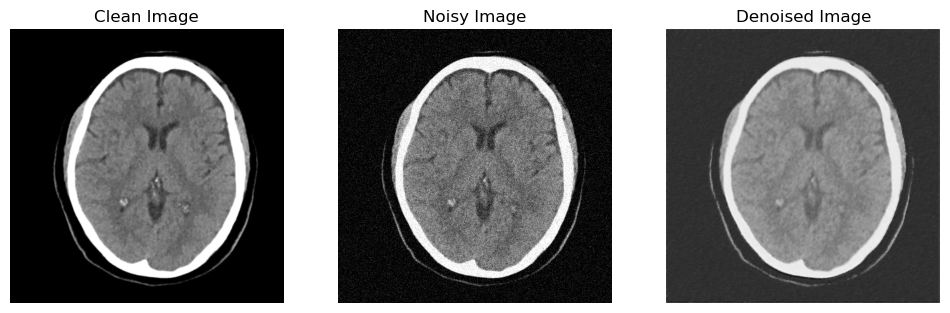

In [5]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import os

# Define the dataset class
class ImageDataset(Dataset):
    def __init__(self, clean_dir, noisy_dir, transform=None):
        self.clean_dir = clean_dir
        self.noisy_dir = noisy_dir
        self.transform = transform
        self.images = os.listdir(clean_dir)  # Assumes identical filenames in both dirs

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        clean_img = Image.open(os.path.join(self.clean_dir, self.images[idx])).convert('L')
        noisy_img = Image.open(os.path.join(self.noisy_dir, self.images[idx])).convert('L')
        
        if self.transform:
            clean_img = self.transform(clean_img)
            noisy_img = self.transform(noisy_img)
        
        return noisy_img, clean_img

# Define the CNN for grayscale images
class DenoisingCNN(nn.Module):
    def __init__(self):
        super(DenoisingCNN, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(16)
        )
        self.decoder = nn.Sequential(
            nn.Conv2d(16, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 1, kernel_size=3, padding=1)  # Output channel is 1 for grayscale
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Transformation for grayscale images
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485], std=[0.229])  # Mean and std dev for a single channel
])

# Load dataset
dataset = ImageDataset('dataset/Clean-10', 'dataset/Noisy-10',transform=transform)
train_loader = DataLoader(dataset, batch_size=10, shuffle=True)

# Set up device and model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DenoisingCNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Train function
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    loss_func = nn.MSELoss()
    for batch_idx, (noisy, clean) in enumerate(train_loader):
        noisy, clean = noisy.to(device), clean.to(device)
        optimizer.zero_grad()
        output = model(noisy)
        loss = loss_func(output, clean)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(noisy)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')

# Plot sample results
def plot_sample(data_loader):
    model.eval()
    with torch.no_grad():
        for noisy, clean in data_loader:
            noisy, clean = noisy.to(device), clean.to(device)
            output = model(noisy)
            fig, axes = plt.subplots(1, 3, figsize=(12, 4))
            axes[0].imshow(clean[0].cpu().squeeze(), cmap='gray')
            axes[0].set_title('Clean Image')
            axes[1].imshow(noisy[0].cpu().squeeze(), cmap='gray')
            axes[1].set_title('Noisy Image')
            axes[2].imshow(output[0].cpu().squeeze(), cmap='gray')
            axes[2].set_title('Denoised Image')
            for ax in axes:
                ax.axis('off')
            plt.show()
            break

# Example usage
for epoch in range(1, 11):  # Train for 10 epochs
    train(model, device, train_loader, optimizer, epoch)

plot_sample(train_loader)  # Plot a sample from the dataset


# Saved The Model

In [6]:
# Path to save the trained model

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import os

model_save_path = 'dataset/DenoisingCNN_model1.pth'

# Save the model's state dictionary
torch.save(model.state_dict(), model_save_path)


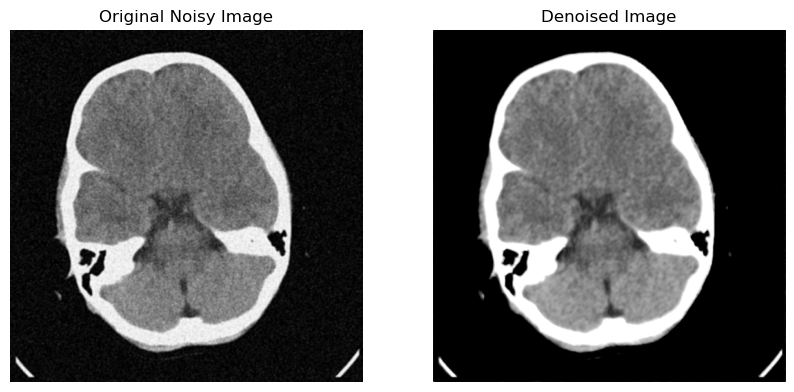

In [ ]:
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt


# Define the CNN for grayscale images
class DenoisingCNN(nn.Module):
    def __init__(self):
        super(DenoisingCNN, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(16)
        )
        self.decoder = nn.Sequential(
            nn.Conv2d(16, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 1, kernel_size=3, padding=1)  # Output channel is 1 for grayscale
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


# Function to load and preprocess the image
def load_image(image_path, transform):
    image = Image.open(image_path).convert('L')  # Convert image to grayscale
    image = transform(image)  # Apply the same transformations as during training
    image = image.unsqueeze(0)  # Add batch dimension
    return image

# Function to convert a tensor to an image for visualization
def tensor_to_image(tensor):
    tensor = tensor.squeeze()  # Remove batch dimension
    tensor = tensor * 0.229 + 0.485  # Unnormalize
    tensor = tensor.clamp(0, 1)  # Clamp to the range [0, 1]
    image = tensor.numpy()
    return image

# Define the transform
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485], std=[0.229])  # Mean and std dev for a single channel
])

# Load the model (Assuming the model and device setup as above)
model = DenoisingCNN().to(device)
model.load_state_dict(torch.load('dataset/DenoisingCNN_model1.pth'))  # Load your trained model weights
model.eval()  # Set the model to evaluation mode

# Load your noisy image
noisy_image_path = 'dataset/Denoised/denoised_image.png'
noisy_image = load_image(noisy_image_path, transform).to(device)


# Get the denoised output
with torch.no_grad():
    denoised_output = model(noisy_image)

# Convert output tensor to image
denoised_output_image = tensor_to_image(denoised_output.cpu().data)

# Plotting the results
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(Image.open(noisy_image_path).convert('L'), cmap='gray')
plt.title('Original Noisy Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(denoised_output_image, cmap='gray')
plt.title('Denoised Image')
plt.axis('off')
plt.show()


### Comparing the Denoised image produced by CNN Model with Noise Image and Clean Image for Evaluation 

In [ ]:

import numpy as np
import matplotlib.pyplot as plt
from skimage import io, img_as_float
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
from sklearn.metrics import mean_squared_error


# Function to calculate SNR
def calculate_snr(signal, reference):
    signal_power = np.mean(reference**2)
    noise_power = np.mean((reference - signal)**2)
    snr = 10 * np.log10(signal_power / noise_power)
    return snr

clean_image_1=clean_image
img_denoised_1=img_denoised
noisy_image_1=noisy_image
clean_image_path = 'dataset/Clean-10/ct118.png'
noisy_image_path = 'dataset/Noisy-10/ct118.png'

img_denoised = denoised_output_image

noisy_image = img_as_float(io.imread(noisy_image_path, as_gray=True))
clean_image = img_as_float(io.imread(clean_image_path, as_gray=True))
mse_2 = mean_squared_error(clean_image_1, img_denoised_1)
snr_noisy = calculate_snr(noisy_image_1, clean_image_1)
snr_denoised_2 = calculate_snr(img_denoised_1, clean_image_1)
ssim_val_2 = ssim(clean_image_1, img_denoised_1, data_range=clean_image.max() - clean_image.min())
psnr_val_2 = psnr(clean_image_1, img_denoised_1, data_range=clean_image.max() - clean_image.min())

print('Comparison metrics for Denoised Image using CNN model with clean and Noise Image:\n')
print(f'Mean Squared Error: {mse_2}')
print(f'SNR of Noisy Image: {snr_noisy:.2f} dB')
print(f'SNR of Denoised Image: {snr_denoised_2:.2f} dB')
print(f'Structural Similarity Index (SSIM): {ssim_val_2:.4f}')
print(f'Peak Signal-to-Noise Ratio (PSNR): {psnr_val_2:.4f}')

Comparison metrics for Denoised Image using CNN model with clean and Noise Image:

Mean Squared Error: 0.0008337164811083216
SNR of Noisy Image: 14.16 dB
SNR of Denoised Image: 23.21 dB
Structural Similarity Index (SSIM): 0.8449
Peak Signal-to-Noise Ratio (PSNR): 30.7898


# 3. Comparing with Another Model:  Gauusian Filtering Comparison

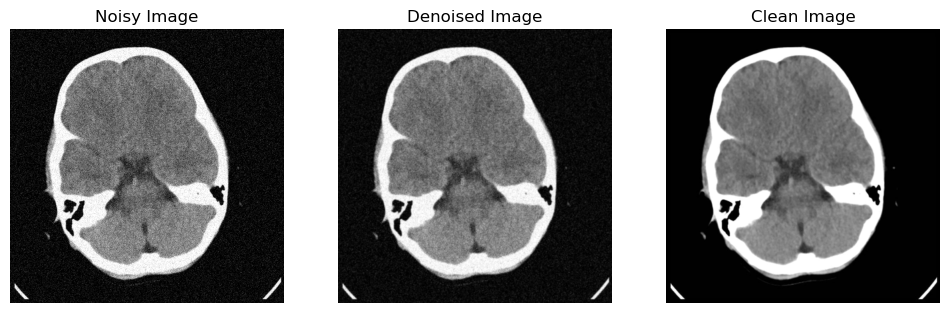

Comparison Metrics for Gauusian Method with clean and Noise Image :

Mean Squared Error: 0.0020356345850028705
SNR of Noisy Image: 14.16 dB
SNR of Denoised Image: 19.34 dB
Structural Similarity Index (SSIM): 0.3990
Peak Signal-to-Noise Ratio (PSNR): 26.9130


In [ ]:
#Code with Gaussian mask with low filter
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, img_as_float
from sklearn.metrics import mean_squared_error

# Function to calculate SNR
def calculate_snr(signal, reference):
    # Calculate signal power and noise power
    signal_power = np.mean(reference**2)
    noise_power = np.mean((reference - signal)**2)
    snr = 10 * np.log10(signal_power / noise_power)
    return snr

# Load your images
noisy_image_path = 'dataset/Noisy-10/ct118.png'
clean_image_path = 'dataset/Clean-10/ct118.png'

noisy_image = img_as_float(io.imread(noisy_image_path, as_gray=True))
clean_image = img_as_float(io.imread(clean_image_path, as_gray=True))

# Step 1: Apply Fourier transform to the noisy image
f_transform = np.fft.fft2(noisy_image)
f_shift = np.fft.fftshift(f_transform)

# Step 2: Create a Gaussian mask as a low-pass filter
rows, cols = noisy_image.shape
center_row, center_col = rows // 2, cols // 2
sigma = 120 # Width of the Gaussian
x, y = np.meshgrid(np.arange(cols) - center_col, np.arange(rows) - center_row)
mask = np.exp(-(x**2 + y**2) / (2 * sigma**2))

# Step 3: Apply the mask and inverse Fourier transform
f_shift_filtered = f_shift * mask
f_ishift = np.fft.ifftshift(f_shift_filtered)
img_back = np.fft.ifft2(f_ishift)
img_denoised = np.abs(img_back)



# Calculate comparison metrics
mse_3 = mean_squared_error(clean_image, img_denoised)
snr_noisy = calculate_snr(noisy_image, clean_image)
snr_denoised_3 = calculate_snr(img_denoised, clean_image)
ssim_val_3 = ssim(clean_image, img_denoised, data_range=clean_image.max() - clean_image.min())
psnr_val_3 = psnr(clean_image, img_denoised, data_range=clean_image.max() - clean_image.min())


# Display the results
plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.imshow(noisy_image, cmap='gray')
plt.title('Noisy Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(img_denoised, cmap='gray')
plt.title('Denoised Image')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(clean_image, cmap='gray')
plt.title('Clean Image')
plt.axis('off')

plt.show()

print('Comparison Metrics for Gauusian Method with clean and Noise Image :\n')
print(f'Mean Squared Error: {mse_3}')
print(f'SNR of Noisy Image: {snr_noisy:.2f} dB')
print(f'SNR of Denoised Image: {snr_denoised_3:.2f} dB')
print(f'Structural Similarity Index (SSIM): {ssim_val_3:.4f}')
print(f'Peak Signal-to-Noise Ratio (PSNR): {psnr_val_3:.4f}')



## Comparing the **Evaluation** metrics using **Graphs** 

### 1. MSE Graph

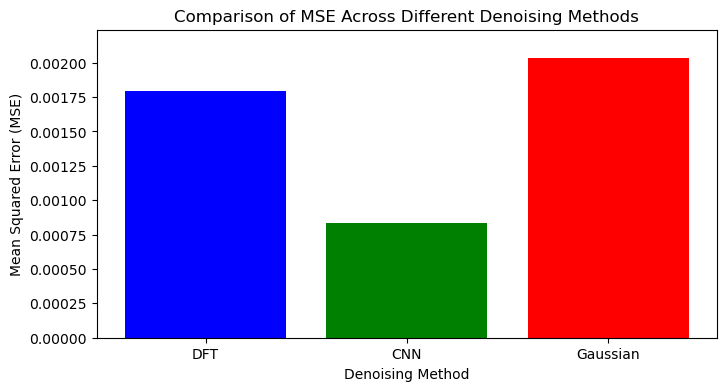

In [ ]:
# Graphs for MSE Values

import matplotlib.pyplot as plt

# MSE values for each method
mse_dft = mse_1  # MSE value for DFT
mse_cnn = mse_2  #  MSE value for CNN
mse_gaussian = mse_3  #  MSE value for Gaussian

# Method names
methods = ['DFT', 'CNN', 'Gaussian']

# Corresponding MSE values
mse_values = [mse_dft, mse_cnn, mse_gaussian]

# Creating the bar chart
plt.figure(figsize=(8, 4))
plt.bar(methods, mse_values, color=['blue', 'green', 'red'])
plt.xlabel('Denoising Method')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Comparison of MSE Across Different Denoising Methods')
plt.ylim([0, max(mse_values) * 1.1])  # Set y-axis limit to be slightly above the highest MSE for clarity
plt.show()


### 2. SNR Graph

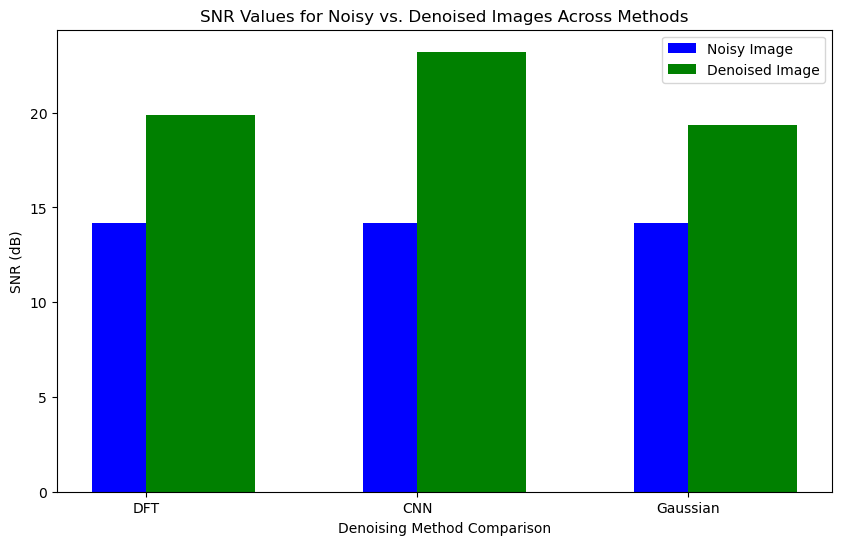

In [24]:
import matplotlib.pyplot as plt

# Predefined SNR values
SNR_NOISY = snr_noisy 
SNR_DENOISED_GRAPH1 = snr_denoised_1
SNR_DENOISED_GRAPH2 = snr_denoised_2
SNR_DENOISED_GRAPH3 = snr_denoised_3

# Method names
methods = ['DFT', 'CNN', 'Gaussian']

# Lists of SNR values for plotting
snr_noisy = [SNR_NOISY] * 3  # Same noisy SNR for all methods
snr_denoised = [SNR_DENOISED_GRAPH1, SNR_DENOISED_GRAPH2, SNR_DENOISED_GRAPH3]

# Creating the bar chart
plt.figure(figsize=(10, 6))
x = range(len(methods))  # the label locations

# Plot bars
plt.bar(x, snr_noisy, width=0.4, label='Noisy Image', color='blue', align='center')
plt.bar(x, snr_denoised, width=0.4, label='Denoised Image', color='green', align='edge')

# Set plot details
plt.xlabel('Denoising Method Comparison')
plt.ylabel('SNR (dB)')
plt.title('SNR Values for Noisy vs. Denoised Images Across Methods')
plt.xticks(x, methods)  # Set labels manually
plt.legend()

plt.show()


### 3. SSIM Graph

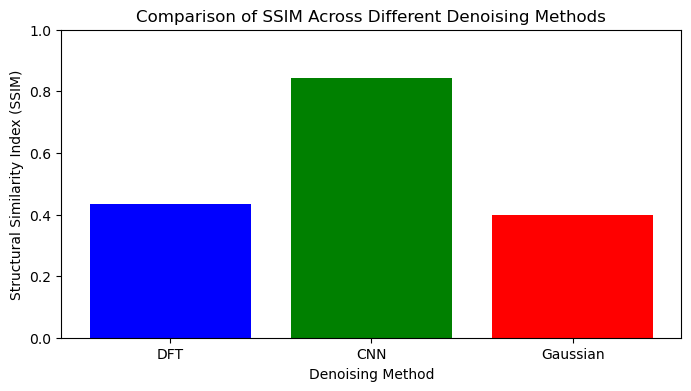

In [25]:
# Graphs for SSIM Comparison

import matplotlib.pyplot as plt

# SSIM values for each method
ssim_dft = ssim_val_1  # Adjust this to your actual MSE value for DFT
ssim_cnn = ssim_val_2  # Adjust this to your actual MSE value for CNN
ssim_gaussian = ssim_val_3  # Adjust this to your actual MSE value for Gaussian

# Method names
methods = ['DFT', 'CNN', 'Gaussian']

# Corresponding SSIM values
ssim_values = [ssim_dft, ssim_cnn, ssim_gaussian]

plt.figure(figsize=(8, 4))
plt.bar(methods, ssim_values, color=['blue', 'green', 'red'])
plt.xlabel('Denoising Method')
plt.ylabel('Structural Similarity Index (SSIM)')
plt.title('Comparison of SSIM Across Different Denoising Methods')
plt.ylim([0, 1])  # SSIM typically ranges from 0 to 1
plt.show()


### 4. PSNR Graph

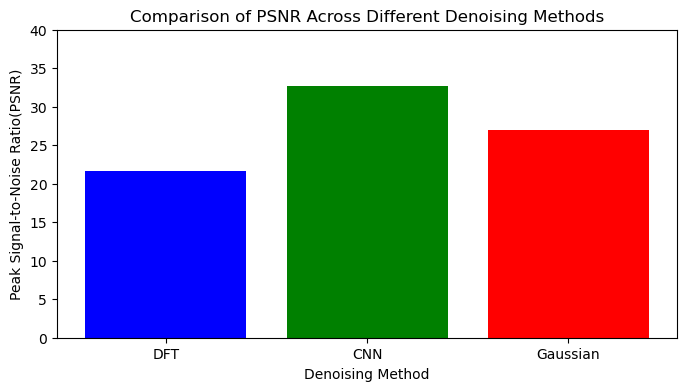

In [14]:
# Graphs for PSNR Comparison

import matplotlib.pyplot as plt

# PSNR values for each method
psnr_dft = psnr_val_1  #  PSNR value for DFT
psnr_cnn = psnr_val_2  # PSNR value for CNN
psnr_gaussian = psnr_val_3 #  PSNR value for Gaussian

# Method names
methods = ['DFT', 'CNN', 'Gaussian']

# Corresponding SSIM values
psnr_values = [psnr_dft, psnr_cnn, psnr_gaussian]

plt.figure(figsize=(8, 4))
plt.bar(methods, psnr_values, color=['blue', 'green', 'red'])
plt.xlabel('Denoising Method')
plt.ylabel('Peak Signal-to-Noise Ratio(PSNR)')
plt.title('Comparison of PSNR Across Different Denoising Methods')
plt.ylim([0, 40])  # PSNR typically ranges from 0 to 40
plt.show()
